## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
parameter_names = c['parameter_names']        
nbidx = 0
print(livetime)
print(folder)

2.154434690031884
Eff_area_PKSflare_crab_cutoff


In [4]:
%%time
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = None)


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 6.08 s, sys: 188 ms, total: 6.27 s
Wall time: 6.29 s


## Datasets

In [5]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
if sys == "Eff_area":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = True
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)


In [6]:
numpoints = 50      
def read_in_contour(note, folder = c['folder'], numpoints = numpoints):
    results = []
    for parname1, parname2 in parameter_names :
        with open(f"../{folder}/data/3_contour_{note}_{parname1}_{parname2}_{numpoints}.yml", "r") as stream:
                contour = yaml.safe_load(stream)

        results.append(contour)
    return results





In [29]:
results = read_in_contour("2.15h",numpoints = "50_10",
                         folder = "Eff_area_PKSflare_crab_cutoff")

results_N = read_in_contour("N_2.15h",numpoints = "50_10",
                         folder = c['folder'])

results_N_comb = read_in_contour("N_2.15h",numpoints = "5_2000",
                           folder = "Combined_PKSflare_crab_cutoff")
path = f'../Combined_PKSflare_crab_cutoff/data/0_model_livetime_{livetime}_np.yml'
dataset_asimov.models = Models.read(path)

contour_eff = 1
if contour_eff:
    results_N_eff = read_in_contour("N_2.15h", numpoints = "50_10",
                                   folder = "Eff_area_PKSflare_crab_cutoff")
    results_eff = read_in_contour("2.15h", numpoints = "50_10",
                                   folder = "Eff_area_PKSflare_crab_cutoff")
    
contour_ereco = 1
if contour_ereco:
    results_N_ereco = read_in_contour("N_2.15h",
                                   folder = "E_reco_PKSflare_crab_cutoff", numpoints = '20_2000')
    
    
try:
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}_np.yml'
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        
except:    
    print("CAUTION: symmetric errors")
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}.yml'
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        
    for p in np.array(parameter_names).flatten():
        dataset_asimov_N.models.parameters[p].error_n =   dataset_asimov_N.models.parameters[p].error         
        dataset_asimov_N.models.parameters[p].error_p =   dataset_asimov_N.models.parameters[p].error 
    
        
        

In [30]:
print(dataset_asimov.models.parameters['index'].error)
print(dataset_asimov.models.parameters['index'].error_n)
print(dataset_asimov.models.parameters['index'].error_p)
print(dataset_asimov.models.parameters['index'].error)

0.08831561350170122
0.09572228927707682
0.09007773167842803
0.08831561350170122


In [9]:
colors_dark = ['darkred', 'midnightblue']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


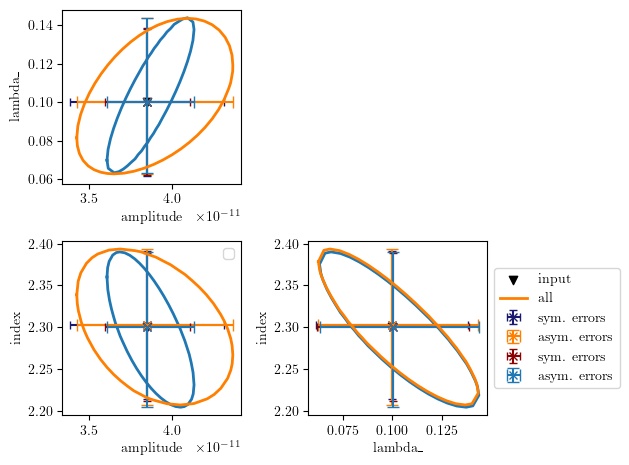

In [52]:
def contour_plot(axs, sys_errors = False, linewidth= 2):
    alpha = 0.2
    
    #fig,axs = plt.subplots(2,2)
    #axs = axs.flatten()
    #axs = [axs[1][0], axs[0][0], axs[1][1], axs[0][1]]
    for i,p in enumerate(parameter_names):
        a = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
        b = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
        axs[i].plot(a, b, color = awo[0], linewidth = linewidth)
        #for j, d in enumerate([dataset_asimov, dataset_asimov_N]):
        for j, d in enumerate([dataset_asimov_N, dataset_asimov]):
            xen = d.models[0].parameters[p[0]].error_n
            xep = d.models[0].parameters[p[0]].error_p
            yen = d.models[0].parameters[p[1]].error_n
            yep = d.models[0].parameters[p[1]].error_p
            
            x = d.models[0].parameters[p[0]].value
            y = d.models[0].parameters[p[1]].value
            xe = d.models[0].parameters[p[0]].error
            ye = d.models[0].parameters[p[1]].error
            if sys_errors:
                axs[i].errorbar(x, y, xerr=np.array([[xe ,xe]]).T,
                            yerr=np.array([[ye ,ye]]).T, color = colors_dark[::-1][j], capsize = 3,
                fmt='x', label = "sym. errors")
            axs[i].errorbar(x, y, xerr=np.array([[xen ,xep]]).T,
                            yerr=np.array([[yen ,yep]]).T, color = colors_[::-1][j], capsize = 4,
                fmt='x',
                           label = "asym. errors")
            
           
        #a = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
        #b = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
        #axs[i].plot(a, b, color = aw[0])
        axs[i].scatter (dataset_input.models[0].parameters[p[0]].value,
                         dataset_input.models[0].parameters[p[1]].value,
                        color = 'black',
                        marker = 'v',
                        label = "input"
                       )
        axs[i].set_xlabel(p[0])
        axs[i].set_ylabel(p[1]) 
        
        if contour_eff:
            a = results_N_eff[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
            b = results_N_eff[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
            axs[i].plot(a, b, color = aw[0], linestyle = 'dotted',
                       label = "Effarea", linewidth = linewidth)
        if contour_ereco:
            a = results_N_ereco[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
            b = results_N_ereco[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
            axs[i].plot(a, b, color = aw[0], linestyle = 'dashed',
                       label = "ereco",linewidth = linewidth )
            
        a = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
        b = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
        axs[i].plot(a, b, color = aw[0], linestyle = 'solid',linewidth = linewidth,
                   label = "all", )
            
    
    return axs

fig,axs = plt.subplots(2,2)
colors_ = [awo[0], aw[0]]
#axs = axs.flatten()
axs[1][0].legend()

axs = [axs[1][0], axs[0][0], axs[1][1], axs[0][1]]
contour_plot(axs, sys_errors= True)
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
axs[-1].axis('off')
plt.savefig(f"../{c['folder']}/plots/7_contours.pdf")

### RNDs

In [11]:
infos = np.loadtxt(f"../{c['folder']}/data/1_P_draw_info.txt")
N_max = 1000
shift_rnds = infos[:N_max, 0]
index_rnds = infos[:N_max, 1]
res_rnds = infos[:N_max, 2]
bias_rnds = infos[:N_max, 3]


pars_N = np.loadtxt(f"../{c['folder']}/data/1_N_P_draw_par.txt")
pars = np.loadtxt(f"../{c['folder']}/data/1_P_draw_par.txt")

lives = pars_N[:N_max, -1:]
print(len(lives))
results_rnds, results_rnds_N = [], []
path = f'../{folder}'
for i in range(len(shift_rnds)):
    s = shift_rnds[i]
    t = index_rnds[i]
    r = res_rnds[i]
    b = bias_rnds[i]
    rnds = f"{s:.6}_{t:.6}_{r:.6}_{b:.6}"
    l = lives[i][0]
    
if c['model'] == "crab_log":
    parameters =  ['amplitude', 'alpha', 'beta', 'norm', 'tilt']
    parameters_hist = ["amplitude", "beta", "alpha"]
    names = {'amplitude':"Amplitude [1/TeVcm2s]", 
        'alpha':"$\\alpha$",
        'beta':"$\\beta$"}
    
if c['model'] == "crab_cutoff":
    parameters =  ['amplitude', 'index', 'lambda_', 'norm', 'tilt']
    parameters_hist = ["amplitude", "index", "lambda_"]
    names = {'amplitude':"Amplitude [1/TeVcm2s]", 
        'index':"$\\Gamma$",
        'lambda_':"1/Cutoff [1/TeV]"}
    
par_values_N = dict()
par_values = dict()
for p in parameters:
    par_values_N[p] = []
    par_values[p] = []

for j in range(len(pars_N)):
    for i in range(len(parameters)):
        #if lives[j] == livetime:
        p = pars_N[j][i*2: i*2+1]
        par_values_N[parameters[i]].append(p)
        p = pars[j][i*2: i*2+1]
        par_values[parameters[i]].append(p)


1000


In [12]:
from scipy.interpolate import interp1d
def interpolate(one, two):
    
    points = np.column_stack((one, two))  # a (nbre_points x nbre_dim) array
    

    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    # Interpolation for different methods: #quadratic
    interpolations_methods = ['linear']
    alpha = np.linspace(0, 1, 75)

    interpolated_points = {}
    for method in interpolations_methods:
        interpolator =  interp1d(distance, points, kind=method, axis=0)
        interpolated_points[method] = interpolator(alpha)
        
    for method_name, curve in interpolated_points.items():
        c_int = {'x':curve.T[0], 'y': curve.T[1]}
    return np.array(c_int['x']), np.array(c_int['y'])



In [42]:
alphas = [0.03, 0.032, 0.043]
alphas2 = [0.06, 0.062, 0.083]
    
def histogram(axs, parameters_hist):
    vs = []
    for i,p_ in enumerate(parameters_hist):
        
        p = dataset_asimov.models[0].parameters[p_]
        r = p.value-sigs[p_] * p.error , p.value+sigs[p_] * p.error
        bins  = np.linspace(r[0], r[1], 25) 
        
        if i ==1:
            orientation = 'horizontal'
            axs[i].set_ylim(p.value-sigs[p_] * p.error , p.value+sigs[p_] * p.error , )
                
        else:
            orientation = 'vertical'
            axs[i].set_xlim(p.value-sigs[p_] * p.error , p.value+sigs[p_] * p.error , )
            
        n, bins, pat = axs[i].hist(np.array(par_values[p_]).ravel(), bins = bins, orientation= orientation,
                                  color = ewo[1],
                                   label = "W/o fitting sys.")
        axs[i].hist(np.array(par_values_N[p_]).ravel(), bins = bins, orientation= orientation,
                     histtype='step', color= ew[0], linewidth = 2, alpha = 0.8,
                    label = "With fitting sys."
                   )
        if i ==1:
            axs[i].hlines(p.value, 0, ax_b.get_xlim()[1], color = 'black', alpha = 0.8)

        else:
            axs[i].vlines(p.value, 0, ax_a.get_ylim()[1], color = 'black', alpha = 0.8)

  
    ax_a.xaxis.set_label_position("top")
    ax_a.set_xlabel(names[parameters_hist[0]])

    ax_b.yaxis.set_label_position("right")
    ax_b.yaxis.tick_right()
    ax_b.set_ylabel(names['index'])#"$\\alpha$",)
    ax_b.tick_params(left = 0, labelleft  = 0,  right = 1,  labelright=1, bottom=1, labelbottom=False)

    ax_c.tick_params(left = 0, labelleft  = 0,  top = 1,  labeltop=1, bottom=1, labelbottom=False)
    ax_c.xaxis.set_label_position("top")
    ax_c.set_xlabel(names['lambda_'])#"$\\alpha$",)

    axs_2.set_xlabel("")
    axs_2.tick_params(top = 0, labeltop  = 0, )
    axs_3.yaxis.set_label_position("right")
    axs_3.yaxis.tick_right()

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.1, 
                        hspace=0.1)
    #axs[i].scatter(par_values[p[0]], par_values[p[1]],marker =  'x', alpha = alpha, color = ewo[0])
    #axs[i].scatter(par_values_N[p[0]], par_values_N[p[1]],marker =  'o', alpha = alpha, color = ew[0])
    return axs

def plot_scatter(axs):
    for i,p in enumerate(parameter_names):
    
        axs[i].scatter(par_values_N[p[0]], par_values_N[p[1]],marker =  'o', alpha = alphas[i], color = ew[0])
        axs[i].scatter(par_values[p[0]], par_values[p[1]],marker =  'x', alpha = alphas2[i], color = ewo[0])


    for i in range(len(results_rnds)):
        r = results_rnds[i]
        r_N = results_rnds_N[i]

        cs = plot_results(r, axs, color = ewo[0])
        cs_N = plot_results(r_N, axs, color = ew[0])
        for i, c_ in enumerate( cases):
            wihtin[c_].append(cs[i])
            wihtin_N[c_].append(cs_N[i])

    for i,p_ in enumerate(parameter_names):
        p = dataset_asimov.models[0].parameters[p_[1]]
        axs[i].set_ylim(p.value-sigs[p_[1]] * p.error , p.value+sigs[p_[1]] * p.error , )
        axs[i].set_ylabel(names[p.name])
        p = dataset_asimov.models[0].parameters[p_[0]]
        axs[i].set_xlim(p.value-sigs[p_[0]] * p.error , p.value+sigs[p_[0]] * p.error , )
        axs[i].set_xlabel(names[p.name])
    plt.tight_layout()
    return axs


def plot_histo(axs, cmap = "Oranges", bins = 20, cmax= 1):
    for i,p in enumerate(parameter_names):
        x_ = [_[0]  for _ in par_values[p[0]]]
        y_ =  [_[0]  for _ in par_values[p[1]]]
        counts, _, _ = np.histogram2d(x_, y_, bins=[bins, bins])
        max_count = counts.max()

        axs[i].hist2d(x_, y_, bins=[30, 30], cmap=cmap, vmax=max_count * cmax) 
        #axs[i].scatter(par_values[p[0]], par_values[p[1]],marker =  'x', alpha = alphas2[i], color = ewo[0])


    for i in range(len(results_rnds)):
        r = results_rnds[i]
        r_N = results_rnds_N[i]

        cs = plot_results(r, axs, color = ewo[0])
        cs_N = plot_results(r_N, axs, color = ew[0])
        for i, c_ in enumerate( cases):
            wihtin[c_].append(cs[i])
            wihtin_N[c_].append(cs_N[i])

    for i,p_ in enumerate(parameter_names):
        p = dataset_asimov.models[0].parameters[p_[1]]
        axs[i].set_ylim(p.value-sigs[p_[1]] * p.error , p.value+sigs[p_[1]] * p.error , )
        axs[i].set_ylabel(names[p.name])
        p = dataset_asimov.models[0].parameters[p_[0]]
        axs[i].set_xlim(p.value-sigs[p_[0]] * p.error , p.value+sigs[p_[0]] * p.error , )
        axs[i].set_xlabel(names[p.name])
    plt.tight_layout()
    return axs


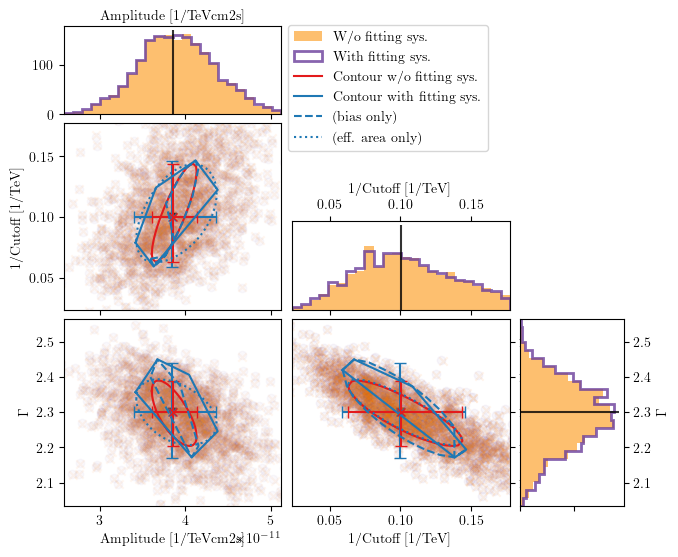

In [14]:
y2 = 2
sigs = {"amplitude":5, 
        "index":3,
        "lambda_":2}

fig3 = plt.figure( figsize = (7,6))
gs = fig3.add_gridspec(5, 5)
ax_a = fig3.add_subplot(gs[0, 0:2])
axs_2 = fig3.add_subplot(gs[1:3, 0:2])
axs_1 = fig3.add_subplot(gs[3:5, 0:2])

ax_c = fig3.add_subplot(gs[2:3,  2:4])
axs_3 = fig3.add_subplot(gs[3:5,  2:4])
ax_b = fig3.add_subplot(gs[3:5,  4:5])

axs = contour_plot([axs_1, axs_2, axs_3])
axs = plot_scatter([axs_1, axs_2, axs_3])

axs = histogram([ax_a, ax_b, ax_c], parameters_hist)


ax_a.plot(np.nan, np.nan, color = awo[0], label = "Contour w/o fitting sys.")
ax_a.plot(np.nan, np.nan, color = aw[0], label = "Contour with fitting sys.")
ax_a.plot(np.nan, np.nan, color = aw[0], linestyle = 'dashed', label = "(bias only)")
ax_a.plot(np.nan, np.nan, color = aw[0], linestyle = 'dotted', label = "(eff. area only)")


ax_a.legend(loc='center left', bbox_to_anchor=(1.0, 0.3))
#axs_1.legend()
plt.show()
fig3.savefig(f"../{c['folder']}/plots/7_summary.pdf") 

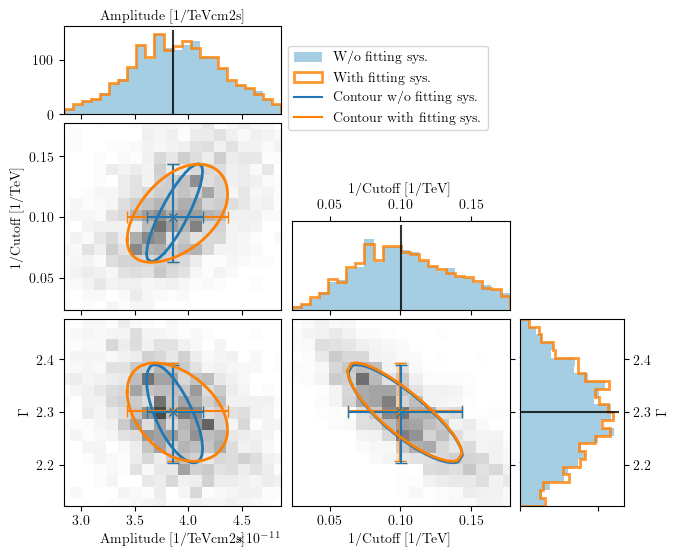

In [61]:
import colors as s
if sys == "Eff_area":
    aw[0] = s.orange
    awo[0] = s.blue
    ew[0]= s.orange
    ewo[0] = s.blue
    ewo[1] = s.lblue
    colors_ = [awo[0], aw[0]]
    
    
    contour_ereco = False
    contour_eff = False
    y2 = 2
    sigs = {"amplitude":4, 
            "index":2,
            "lambda_":2}

    fig3 = plt.figure( figsize = (7,6))
    gs = fig3.add_gridspec(5, 5)
    ax_a = fig3.add_subplot(gs[0, 0:2])
    axs_2 = fig3.add_subplot(gs[1:3, 0:2])
    axs_1 = fig3.add_subplot(gs[3:5, 0:2])

    ax_c = fig3.add_subplot(gs[2:3,  2:4])
    axs_3 = fig3.add_subplot(gs[3:5,  2:4])
    ax_b = fig3.add_subplot(gs[3:5,  4:5])

    axs = contour_plot([axs_1, axs_2, axs_3])
    axs = plot_histo([axs_1, axs_2, axs_3], cmap = "Greys", bins = 80, cmax = 5.0)

    axs = histogram([ax_a, ax_b, ax_c], parameters_hist)


    ax_a.plot(np.nan, np.nan, color = awo[0], label = "Contour w/o fitting sys.")
    ax_a.plot(np.nan, np.nan, color = aw[0], label = "Contour with fitting sys.")


    ax_a.legend(loc='center left', bbox_to_anchor=(1.0, 0.3))
    #axs_1.legend()
    plt.show()
    fig3.savefig(f"../{c['folder']}/plots/7_summary_hist.pdf") 

In [16]:
import matplotlib.path as mpltPath
withins, withins_N = [] , []
cases = ["No sys", "all sys", "ereco", "eff area" ]
for r, case in zip([results,results_N,  results_N_ereco, results_N_eff], cases):
    w = []
    print(case)
    for i,p in enumerate(parameter_names):
        try:
            a = r[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
            b = r[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
            path = mpltPath.Path(np.column_stack((a, b)))
        except:
            dat = r[i].allsegs[0][0]
            a = dat[:, 1]
            b = dat[:, 0]
            path = mpltPath.Path(np.column_stack((a, b)))
            
        masks = []
        for pars0, pars1 in zip(par_values[p[0]], par_values[p[1]]):
            mask = path.contains_points(points = ([(pars0[0], pars1[0])]))
            masks.append(mask[0])
        withins.append(np.count_nonzero(masks)/ len(masks))
        
        for pars0, pars1 in zip(par_values_N[p[0]], par_values_N[p[1]]):
            mask = path.contains_points(points = ([(pars0[0], pars1[0])]))
            masks.append(mask[0])
        withins_N.append(np.count_nonzero(masks)/ len(masks))
        
        print(p[0], p[1], withins[-1], withins_N[-1])
    print()
print(withins)



No sys
amplitude index 0.1913477537437604 0.19079312257348863
amplitude lambda_ 0.15030504714364948 0.15113699389905713
lambda_ index 0.3899057127010538 0.38879645036051025

all sys
amplitude index 0.40099833610648916 0.4023849140321686
amplitude lambda_ 0.3089295618413755 0.30809761508596784
lambda_ index 0.2967276760953966 0.2961730449251248

ereco
amplitude index 0.16472545757071547 0.16528008874098724
amplitude lambda_ 0.08763172490293955 0.0904048807542984
lambda_ index 0.5307820299500832 0.5302273987798114

eff area
amplitude index 0.41985579589572936 0.415973377703827
amplitude lambda_ 0.3982251802551303 0.39739323349972266
lambda_ index 0.3915696062118691 0.391846921797005

[0.1913477537437604, 0.15030504714364948, 0.3899057127010538, 0.40099833610648916, 0.3089295618413755, 0.2967276760953966, 0.16472545757071547, 0.08763172490293955, 0.5307820299500832, 0.41985579589572936, 0.3982251802551303, 0.3915696062118691]


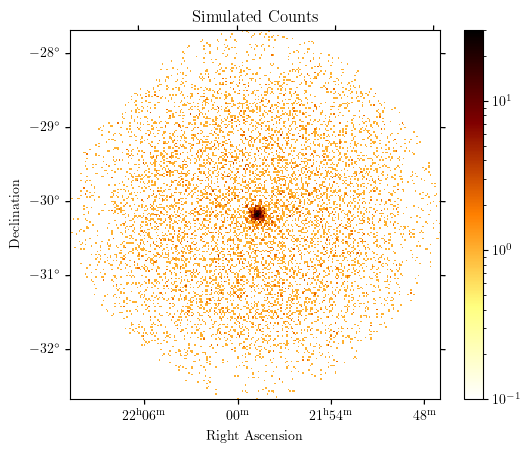

In [17]:
dataset_stat = dataset_asimov.copy()
dataset_stat.counts.data = np.random.poisson(dataset_asimov.npred().data)
from matplotlib.colors import LogNorm
ax= dataset_stat.counts.sum_over_axes().cutout(dataset_stat.counts.geom.center_skydir,
                                           5*u.deg).plot(add_cbar = 1,norm = LogNorm(vmin = 0.1, 
                                                                        vmax = 30),
                                                        cmap = "afmhot_r")

ax.set_title("Simulated Counts")
fig = plt.gcf()
fig.savefig(f"../{c['folder']}/plots/7_counts.pdf")             

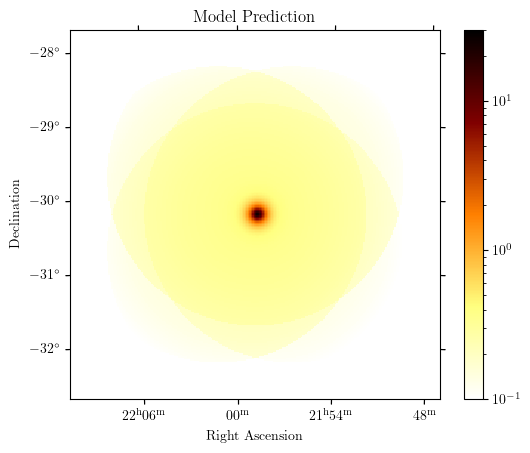

In [18]:
ax = dataset_asimov.npred().sum_over_axes().cutout(dataset_stat.counts.geom.center_skydir,
                                           5*u.deg).plot(add_cbar = 1, norm = LogNorm(vmin = 0.1, 
                                                                        vmax = 30),
                                                        cmap = "afmhot_r")
ax.set_title("Model Prediction")
fig = plt.gcf()
fig.savefig(f"../{c['folder']}/plots/7_model_pred.pdf")             